In [1]:
# ───────────────────── 1. LIBRERÍAS ─────────────────────────────
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cartopy.crs as ccrs
from matplotlib import colormaps
from pathlib import Path
import matplotlib.ticker as mticker
from utils import decimal_to_datetime, norm_dep
from matplotlib.lines import Line2D
import numpy as np
from matplotlib.patches import FancyArrowPatch
import random
import matplotlib.cm as cm
import matplotlib.colors as colors
from adjustText import adjust_text
import matplotlib.font_manager as fm

In [2]:
# ───────────────────── 2. CONFIGURACIÓN DE FUENTES ─────────────────────────────

# Ruta al archivo .ttf de Arial
arial_fp = fm.FontProperties(fname='../src//font/Arial.ttf')
arial_name = arial_fp.get_name()

print("Nombre de la fuente registrada desde el archivo:", arial_name)

Nombre de la fuente registrada desde el archivo: Arial


In [3]:
# ───────────────────── 3. CARGA DE DATOS ───────────────────────
# Lee el archivo
file = Path("../data/Fig3_AllPeru_RegionDateMovements.txt")
df   = pd.read_csv(file, sep="\t")

# Convierte fechas decimales a datetime
for col in ("ParentDate", "ChildDate"):
    df[col] = df[col].apply(decimal_to_datetime)

# Normaliza nombres de regiones
for col in ("ParentRegion", "ChildRegion"):
    df[col] = df[col].apply(norm_dep)

# Agrega columnas de tiempo
df['año'] = df['ParentDate'].dt.year
df['mes'] = df['ParentDate'].dt.month
df['trimestre'] = df['ParentDate'].dt.quarter
df = df.sort_values('ParentDate')

# Agrupa movimientos por ruta única
df_count = df.groupby(["ParentRegion", "ChildRegion"]).size().reset_index(name="count")

# Define la normalización para color
min_count = df_count['count'].min()
max_count = df_count['count'].max()
print(f"Min count: {min_count}, Max count: {max_count}")  # ← para verificar que es 1 a 1556

## Normalización logarítmica para el colormap
norm = colors.Normalize(vmin=min_count, vmax=max_count)
# cmap = cm.get_cmap('Purples')/
cmap = plt.colormaps['Purples']

Min count: 1, Max count: 1556


In [4]:
# ───────────────────── 4. SHAPEFILE Y CENTROIDES ───────────────
shp = "../data/DEPARTAMENTOS_inei_geogpsperu_suyopomalia/DEPARTAMENTOS_inei_geogpsperu_suyopomalia.shp"
gdf = gpd.read_file(shp)
# 1.  Proyección métrica adecuada para Perú  ──────────
#    UTM zona 18 Sur (EPSG:32718) cubre la mayor parte del país.
gdf_m = gdf.to_crs("EPSG:32718")
# 2.  Centroides en metros  ───────────────────────────
centroids_xy = gdf_m.centroid            # punto (x, y) en metros
# 3.  De vuelta a lon/lat  ───────────────────────────
centroids_ll = centroids_xy.to_crs("EPSG:4326")   # WGS-84

gdf["NOMBDEP"] = gdf["NOMBDEP"].apply(norm_dep)

# 4.  Diccionario {DEP: (lon, lat)}  ─────────────────
coords = {dep: (pt.x, pt.y)
          for dep, pt in zip(gdf["NOMBDEP"], centroids_ll)}

In [5]:
# ───────────────────── 5. ESTADÍSTICAS PARA TAMAÑOS Y COLORES ──
donor_total = df["ParentRegion"].value_counts()
max_don     = donor_total.max()
size_lut    = ((donor_total / max_don) ** 0.5) * 900    # escala subjetiva

num_dates   = mdates.date2num(df["ParentDate"])
norm        = mcolors.Normalize(vmin=num_dates.min(), vmax=num_dates.max())
sm          = cm.ScalarMappable(norm=norm, cmap="viridis")

# paleta pastel para relleno de departamentos
N = len(gdf)                     # nº de departamentos
pastel = colormaps.get_cmap("Pastel2").resampled(N)
fill_color = {dep: pastel(i) for i, dep in enumerate(sorted(gdf["NOMBDEP"]))}

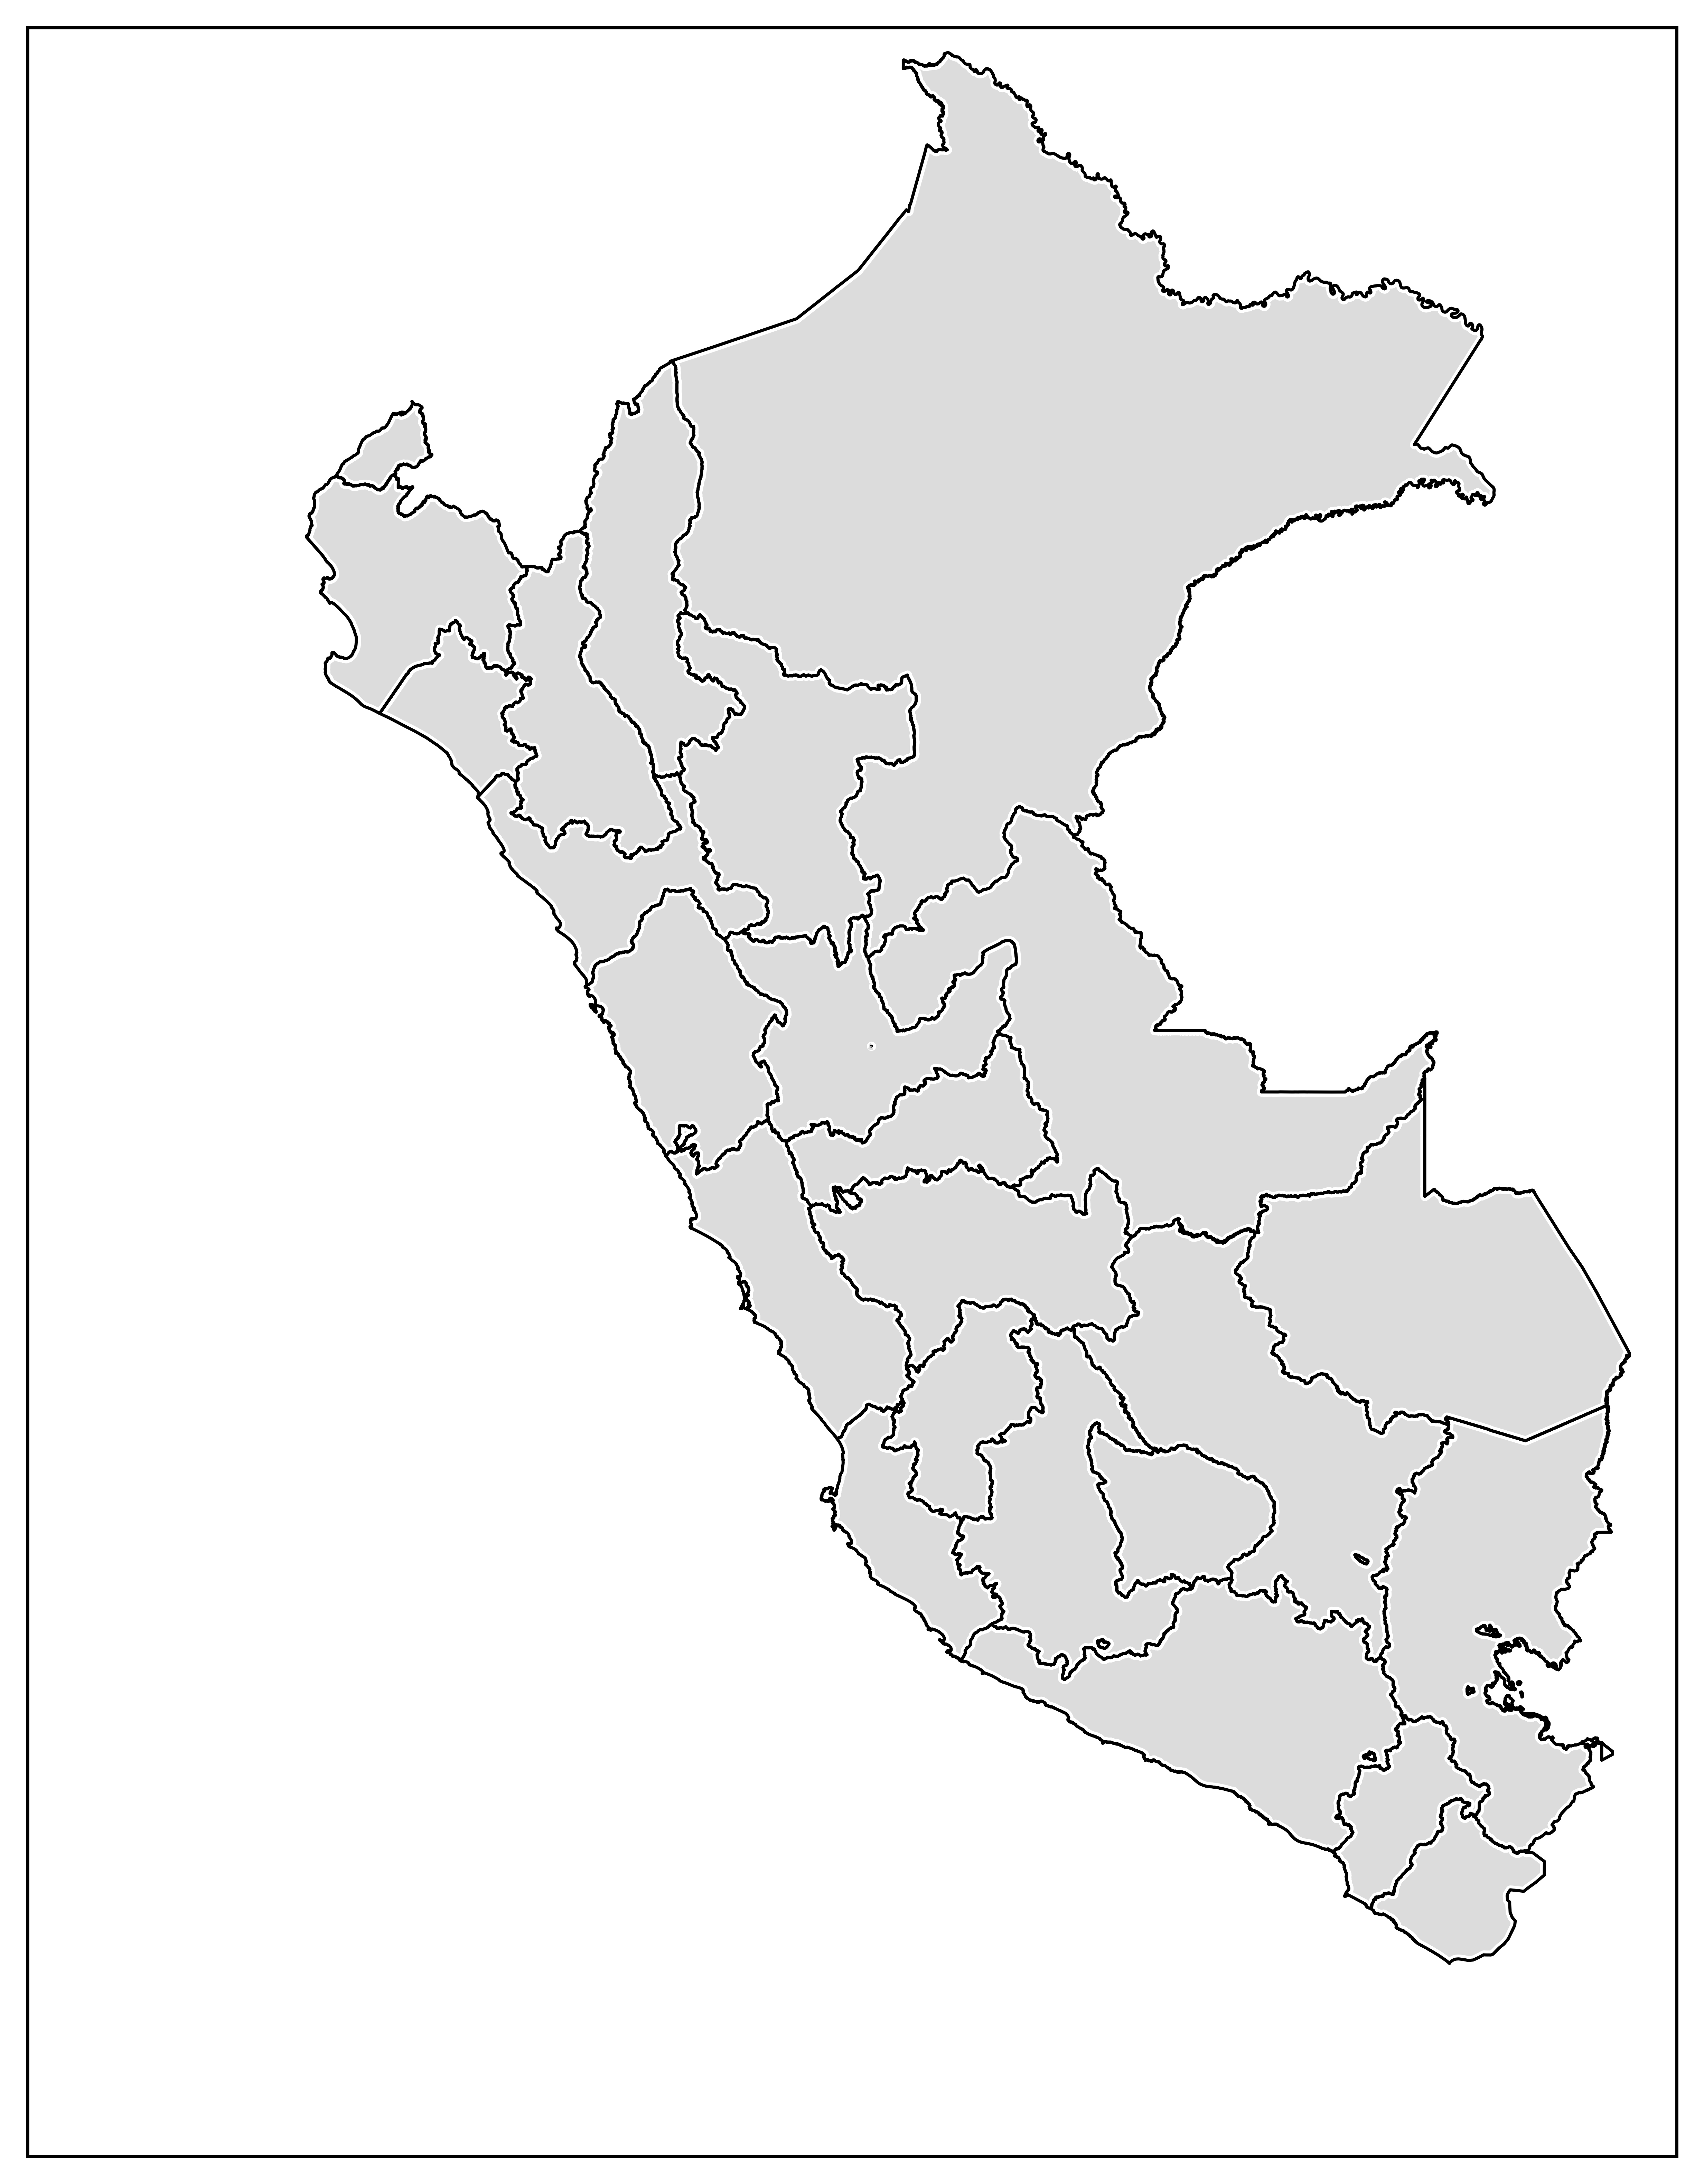

In [6]:
# ───────────────────── 6. FIGURA Y MAPA BASE ───────────────────
fig = plt.figure(figsize=(8, 10), dpi=800)
ax  = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-84, -68.2, -20.2, 0.2])

# relleno pastel + borde doble (halo blanco + línea negra)
for dep, geom in zip(gdf["NOMBDEP"], gdf.geometry):
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      # facecolor=fill_color[dep],
                      facecolor="gainsboro",     # <-- siempre el mismo
                      edgecolor="white",
                      linewidth=2.4, zorder=0)
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      facecolor="none",
                      edgecolor="black",
                      linewidth=0.8, zorder=1)

In [7]:
# ───────────────────── 7. ARCOS Y FLECHAS ──────────────────────
# Asegúrate de que la normalización logarítmica esté definida aquí
min_count = df_count['count'].min()
max_count = df_count['count'].max()
norm_log = colors.LogNorm(vmin=min_count, vmax=max_count)
# Cambia el colormap a uno que empiece en blanco y termine fuerte, por ejemplo 'Reds'
cmap = plt.colormaps['Purples']

# Ordena df_count por 'count' en orden descendente
df_count_sorted = df_count.sort_values(by='count', ascending=False)

# Define un zorder máximo para las flechas
max_arrow_zorder = 100 # Ajusta este valor si es necesario

def bezier(x_start, y_start, x_end, y_end, rad=0.2, n_points=100):
    """
    Genera puntos de una curva de Bézier cuadrática entre dos puntos,
    con una curvatura especificada por `rad` y una cantidad de puntos `n_points`.
    """
    # Punto de control para la curva (curvatura)
    ctrl_x = (x_start + x_end) / 2 - rad * (y_end - y_start)
    ctrl_y = (y_start + y_end) / 2 + rad * (x_end - x_start)

    t = np.linspace(0, 1, n_points)
    x_vals = (1 - t)**2 * x_start + 2 * (1 - t) * t * ctrl_x + t**2 * x_end
    y_vals = (1 - t)**2 * y_start + 2 * (1 - t) * t * ctrl_y + t**2 * y_end

    return x_vals, y_vals

for _, row in df_count_sorted.iterrows():
    parent = row["ParentRegion"]
    child = row["ChildRegion"]
    count = row["count"]

    x_start, y_start = coords[parent]
    x_end, y_end = coords[child]

    rad = random.choice([-0.3, -0.2, -0.1, 0.1, 0.2, 0.3])
    color = cmap(norm_log(count))

    alpha_value = norm_log(count)
    alpha_value = max(0.1, min(0.9, alpha_value))

    if count > 1000:
        linewidth_value = 1.5
    elif count >= 500:
        linewidth_value = 1.0
    else:
        linewidth_value = 0.5

    zorder_value = max_arrow_zorder * (count - min_count) / (max_count - min_count)
    zorder_value = max(1, zorder_value)

    # (1) Dibuja curva con función bezier:
    x_vals, y_vals = bezier(x_start, y_start, x_end, y_end, rad, n_points=100)
    ax.plot(x_vals, y_vals, color=color, linewidth=linewidth_value, alpha=alpha_value,
            transform=ccrs.PlateCarree(), zorder=zorder_value)

    # (2) Flecha en punto medio de la curva:
    mid_idx = len(x_vals) // 2
    ax.annotate("",
        xy=(x_vals[mid_idx + 1], y_vals[mid_idx + 1]),
        xytext=(x_vals[mid_idx - 1], y_vals[mid_idx - 1]),
        arrowprops=dict(arrowstyle="->", color=color, lw=linewidth_value),
        annotation_clip=False,
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        zorder=zorder_value + 1
    )

In [8]:
# ───────────────────── 8. MAPA COROPLÉTICO DE DENSIDAD POBLACIONAL ───────

try:
    # Carga los datos de densidad poblacional
    df_densidad = pd.read_csv("..//data/densidad_poblacional.csv")

    # Asegúrate de que la columna de departamento tenga el nombre correcto y normalízala
    if 'Departamento' in df_densidad.columns:
        df_densidad['Departamento'] = df_densidad['Departamento'].apply(norm_dep)
    else:
        print("Advertencia: Columna 'Departamento' no encontrada...")
        raise KeyError("Columna 'Departamento' no encontrada")
    gdf_con_densidad = gdf.set_index('NOMBDEP').join(df_densidad.set_index('Departamento'))
    if 'Densidad' not in gdf_con_densidad.columns:
        print("Error: La unión de datos de densidad no fue exitosa...")
        raise ValueError("Columna 'Densidad' no encontrada después de la unión.")

    # --- Prepara el mapa coroplético ---
    # cmap_densidad = cm.get_cmap('Blues')
    cmap_densidad = plt.colormaps['Blues']
    min_densidad = gdf_con_densidad['Densidad'].min()
    max_densidad = gdf_con_densidad['Densidad'].max()
    
    # --- Cambia a normalización logarítmica ---
    vmin_log = max(1, min_densidad)
    norm_densidad = colors.LogNorm(vmin=vmin_log, vmax=max_densidad)

    # --- Dibuja el mapa coroplético ---
    gdf_con_densidad.plot(column='Densidad',
                          ax=ax,
                          cmap=cmap_densidad,
                          norm=norm_densidad,
                          edgecolor="black",
                          linewidth=0.5,
                          legend=False,
                          zorder=2
                         )

    # --- Agrega una barra de color (colorbar) para la densidad usando un nuevo eje ---
    # Define la posición y tamaño del nuevo eje para el colorbar
    cbar_ax = fig.add_axes([0.18, 0.30, 0.02,0.3]) # Ajusta [left, bottom, width, height] según tu necesidad

    # Crea el colorbar en el nuevo eje
    sm_densidad = cm.ScalarMappable(norm=norm_densidad, cmap=cmap_densidad)
    sm_densidad.set_array([])
    cbar = fig.colorbar(sm_densidad, cax=cbar_ax, orientation='vertical')

    # Establece la etiqueta usando el método set_ylabel del eje del colorbar
    # Ajusta labelpad para la distancia
    cbar.ax.set_ylabel('Population Density', fontproperties=arial_fp,
                       labelpad=15, # Ajusta el espacio entre la etiqueta y el colorbar
                       loc='center', # Alinea verticalmente en el centro
                       rotation=90) # Rota el texto 90 grados

    # Control fino de la posición de la etiqueta en coordenadas relativas al eje del colorbar
    cbar.ax.yaxis.set_label_coords(-0.9, 0.5)


    # Asegúrate de que los ticks de la barra de color sean legibles
    if isinstance(norm_densidad, colors.LogNorm):
        from matplotlib.ticker import LogLocator, NullFormatter
        cbar.ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
        # cbar.ax.yaxis.set_minor_formatter(NullFormatter())
        # cbar.ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        # Utilice LogFormatter para formatear las marcas correctamente para la escala logarítmica
        cbar.ax.yaxis.set_major_formatter(mticker.LogFormatter(base=10.0, labelOnlyBase=False))
        cbar.ax.tick_params(labelsize=8)

    print("Mapa coroplético de densidad poblacional dibujado.")


except FileNotFoundError:
    print("Error: El archivo 'densidad_poblacional.csv' no fue encontrado.")
except KeyError as e:
    print(f"Error de columna o unión: {e}")
except ValueError as e:
    print(f"Error de datos o unión: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado al procesar la densidad: {e}")

Mapa coroplético de densidad poblacional dibujado.


In [9]:
# ───────────────────── 9. PUNTOS Y ETIQUETAS ───────────────────
FACE = (0.886, 0.290, 0.200, 0.8)  # naranja-rojo 80 %
label_zorder = max_arrow_zorder + 10 # Un valor mayor que el zorder máximo de las flechas

# Lista para almacenar los objetos de texto
texts = []

for dep, (lon, lat) in coords.items():
    size_px = size_lut.get(dep, 80)
    circ = Circle((lon, lat), size_px/2200, facecolor=FACE,
                  edgecolor="white", lw=0.6, zorder=4,
                  transform=ccrs.PlateCarree())
    ax.add_patch(circ)

    # --- Ajuste Manual de Coordenadas para Departamentos Específicos ---
    adjusted_lon = lon
    adjusted_lat = lat
    offset_lat = 0.15 if lat > -10 else -0.15 # Offset vertical base
    offset_lon = 0.05 # Offset horizontal base

    # Ajustes específicos basados en la observación de los solapamientos
    if dep == 'Lambayeque':
        adjusted_lon -= 0.5 # Mover ligeramente a la izquierda
        adjusted_lat += 0.5 # Mover ligeramente hacia arriba
    elif dep == 'Cajamarca':
        adjusted_lon += 0.35 # Mover ligeramente a la derecha
        adjusted_lat -= 0.35 # Mover ligeramente hacia abajo
    elif dep == 'Lima':
         adjusted_lon += 0.15 # Mover más a la derecha
         offset_lat += 0.1 # Añadir un offset vertical extra
    elif dep == 'Callao':
         adjusted_lon -= 0.15 # Mover más a la izquierda
         offset_lat -= 0.1 # Añadir un offset vertical extra (negativo)
    elif dep == 'Ayacucho':
         adjusted_lon -= 0.1 # Mover ligeramente a la izquierda
         offset_lat += 0.08 # Añadir un offset vertical extra
    elif dep == 'Apurimac':
         adjusted_lon += 0.1 # Mover ligeramente a la derecha
         offset_lat -= 0.08 # Añadir un offset vertical extra (negativo)

    # Aplica el offset (base + manual si aplica)
    final_lon = adjusted_lon + offset_lon
    final_lat = adjusted_lat + offset_lat

    # Crea el objeto de texto con las coordenadas ajustadas
    texts.append(ax.text(final_lon, final_lat, dep.title(),
                          fontsize=8, ha="left", va="center", zorder=label_zorder,
                          bbox=dict(facecolor="white", alpha=.7, pad=1, lw=0),
                          transform=ccrs.PlateCarree(),
                          fontproperties=arial_fp))

# Después del bucle, llama a adjust_text con parámetros de force_points y force_text razonables
adjust_text(texts, ax=ax,
            force_points=(1.0, 1.0), # Ajusta estos valores según necesites la separación general
            force_text=(1.0, 1.0),
            expand_points=(1.1, 1.1),
            expand_text=(1.1, 1.1),
            arrowprops=dict(arrowstyle='-', color='none', lw=0.5, shrinkA=10, shrinkB=10)) # Opciones para el ajuste

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


([Text(-77.26701019735931, -5.064907997881022, 'Amazonas'),
  Text(-77.09633143697918, -9.32225768997109, 'Ancash'),
  Text(-72.19864700516777, -14.032309867590287, 'Apurimac'),
  Text(-71.79974670401674, -16.07001308948951, 'Arequipa'),
  Text(-73.4051084923982, -14.39840988097976, 'Ayacucho'),
  Text(-77.91435202029933, -6.354420972560739, 'Cajamarca'),
  Text(-76.62987991608014, -12.24595833825155, 'Callao'),
  Text(-71.67656812130032, -13.389700963909902, 'Cusco'),
  Text(-74.02717173349438, -13.011258957956564, 'Huancavelica'),
  Text(-75.34893725513993, -9.34228268192816, 'Huanuco'),
  Text(-75.31595714652943, -14.359981999966369, 'Ica'),
  Text(-74.45333518407665, -11.728464785478495, 'Junin'),
  Text(-77.53721781843261, -7.917036008874538, 'La Libertad'),
  Text(-78.94551333474139, -6.024704215496971, 'Lambayeque'),
  Text(-76.22645260240871, -11.83096055527866, 'Lima'),
  Text(-73.92700923127208, -4.020387609656787, 'Loreto'),
  Text(-69.4423746862371, -12.283670199283764, 'Ma

In [10]:
# ───────────────────── 10. ESCALA 200 km ───────────────────────
bar = AnchoredSizeBar(ax.transData, 1.2, '200 km', loc=4,
                      pad=0.6, color='black',
                      frameon=False, size_vertical=0.10,
                      fontproperties=arial_fp)
ax.add_artist(bar)

In [11]:
# ───────────────────── 11. COMPASS ROSE ───────────

# Define la posición central del compass rose
compass_x = -82.6
compass_y = -1.2

# Define el tamaño general del compass rose
compass_size = 0.8

# Longitud de las líneas cardinales
cardinal_length = compass_size * 0.6

# Zorder para el compass rose
compass_zorder = 50

# --- Dibuja las líneas cardinales (Norte, Sur, Este, Oeste) ---
# Línea Norte-Sur
ax.plot([compass_x, compass_x],
        [compass_y - cardinal_length, compass_y + cardinal_length],
        color='black', lw=1.5, transform=ccrs.PlateCarree(), zorder=compass_zorder)

# Línea Este-Oeste
ax.plot([compass_x - cardinal_length, compass_x + cardinal_length],
        [compass_y, compass_y],
        color='black', lw=1.5, transform=ccrs.PlateCarree(), zorder=compass_zorder)

# --- Agrega las etiquetas cardinales ---
# Etiqueta Norte
ax.text(compass_x, compass_y + cardinal_length + 0.1, 'N',
        fontsize=9, ha='center', va='bottom', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# Etiqueta Sur (ajusta posición)
ax.text(compass_x, compass_y - cardinal_length - 0.1, 'S',
        fontsize=9, ha='center', va='top', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# Etiqueta Este (ajusta posición)
ax.text(compass_x + cardinal_length + 0.1, compass_y, 'E',
        fontsize=9, ha='left', va='center', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# Etiqueta Oeste (ajusta posición)
ax.text(compass_x - cardinal_length - 0.1, compass_y, 'W',
        fontsize=9, ha='right', va='center', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# --- Añade punta de flecha Norte ---
north_tip = FancyArrowPatch((compass_x, compass_y + cardinal_length - 0.1),
                             (compass_x, compass_y + cardinal_length + 0.1),
                             mutation_scale=10,
                             lw=1.5, color='black', capstyle='round',
                             arrowstyle='-|>',
                             transform=ccrs.PlateCarree(),
                             zorder=compass_zorder)
ax.add_patch(north_tip)

In [12]:
# ───────────────────── 12. TÍTULO Y PIE ────────────────────────
plt.suptitle("Dispersión de linajes virales entre departamentos del Perú (2020-2024)",
             fontsize=13, fontweight='bold', y=0.988,
             fontproperties=arial_fp)
bbox = ax.get_position()
# caption = (
#     "Figura 1 | Arcos coloreados según la fecha origen del evento (ParentDate). Los círculos se escalan al número total de eventos registrados \n"
#     "como origen para cada departamento. El fondo muestra los límites administrativos proporcionados por el INEI."
# )
# Bbox(x0, y0, x1, y1)
# Opcional: envolver a ~90 caracteres para evitar líneas ultra-largas
# wrapped = "\n".join(textwrap.wrap(caption, 90))
# ── 3. Coordenadas del centro del mapa ─────────────────────────
# x_center = bbox.x0 + bbox.width / 2
# y_bottom = 0.01                # distancia vertical en fracción de figura
# ── 4. Dibujar texto centrado y con alineación adecuada ────────
# fig.text(
#     x_center, y_bottom,
#     caption,
#     ha="center", va="bottom",
#     fontsize=6.5,
#     wrap=True                  # Matplotlib ≥3.4 respeta saltos automáticos
# )

<Figure size 640x480 with 0 Axes>

In [13]:
# ───────────────────── 13. LEYENDA COMBINADA ────────────────────────

# Define los rangos de cantidad y sus propiedades de visualización para las flechas
legend_ranges_arrows = [
    (1, 50, 0.5, 'Low'),
    (51, 500, 0.8, 'Medium-Low'),
    (501, 1000, 1.2, 'Medium-High'),
    (1001, max_count, 1.8, 'High')
]

# --- Crear manejadores y etiquetas para la leyenda de flechas ---
legend_handles_arrows = []
legend_labels_arrows = []

# Ten definido la normalización logarítmica y el colormap para las flechas
min_count = df_count['count'].min()
max_count = df_count['count'].max()
norm_log = colors.LogNorm(vmin=min_count, vmax=max_count)
# cmap = cm.get_cmap('Purples') # O 'Blues', 'Purples', 'Purples', 'Oranges', etc.
cmap = plt.colormaps['Purples']

for min_val, max_val, linewidth, label_range in legend_ranges_arrows:
    representative_count = (min_val + max_val) / 2 # Usa el punto medio para la muestra de color
    try:
        color = cmap(norm_log(representative_count))
    except ValueError:
        if representative_count < min_count:
            color = cmap(norm_log(min_count))
        else:
            color = cmap(norm_log(max_count))

    handle = Line2D([0], [0], color=color, lw=linewidth)
    legend_handles_arrows.append(handle)
    # Formato "Palabra Descriptiva: Rango Numérico"
    legend_labels_arrows.append(f'{min_val}-{max_val}')

# --- Creación de la Leyenda "Movements from Origin Department" con ax.legend ---

# Asegúrate de que donor_total esté disponible y tenga datos
if 'donor_total' in locals() and isinstance(donor_total, pd.Series) and not donor_total.empty:

    # Define los rangos de la cantidad total de movimientos de origen usando cuartiles
    q1 = donor_total.quantile(0.33)
    q2 = donor_total.quantile(0.66)
    min_don = donor_total.min()
    max_don = donor_total.max()


    legend_ranges_circles = [
        (min_don, q1, 'Low'),
        (q1 + 1, q2, 'Medium'),
        (q2 + 1, max_don, 'High')
    ]

    legend_handles_circles = []
    legend_labels_circles = []

    circle_color = FACE
    legend_size_factor = 0.02

    # Define valores representativos para calcular el tamaño de la leyenda
    representative_counts = [q1, q2, max_don]


    for i, (min_val, max_val, label_range) in enumerate(legend_ranges_circles):

        if i < len(representative_counts):
            representative_count = representative_counts[i]
        else:
            representative_count = max_val

        representative_count = max(1, representative_count)


        if max_don > 0:
             representative_size = ((representative_count / max_don) ** 0.5) * 900
        else:
             representative_size = 0

        legend_markersize = representative_size * legend_size_factor
        legend_markersize = max(1, legend_markersize)

        handle = Line2D([0], [0], marker='o', color='w',
                           markerfacecolor=circle_color, markersize=legend_markersize)
        legend_handles_circles.append(handle)

        # Muestra el rango numérico de movimientos
        if isinstance(min_val, (int, float)) and isinstance(max_val, (int, float)):
            
            legend_labels_circles.append(f'{int(round(min_val))}-{int(round(max_val))}')
        else:
            legend_labels_circles.append(f'{int(round(min_val))}-{int(round(max_val))}')


    # Crea la leyenda para los círculos rojos (Origen de Dispersión) con tamaño variable
    legend_circles = ax.legend(handles=legend_handles_circles, labels=legend_labels_circles,
                               title="Movements from Origin",
                               loc='lower left',
                               bbox_to_anchor=(0, 0.095),
                               prop=arial_fp,
                               handletextpad=0.8,
                               handlelength=2.0,
                               labelspacing=0.5,
                               )

    ax.add_artist(legend_circles)


else:
    print("Advertencia: donor_total no está definido, está vacío o no es un tipo esperado. No se agregará la leyenda de círculos.")


# --- Creación de la Leyenda (Route) ---

# Crea la leyenda combinada (color y grosor de las flechas)
legend_combined = ax.legend(handles=legend_handles_arrows, labels=legend_labels_arrows,
                            title="Number of Movements",
                            loc='lower left',
                            bbox_to_anchor=(0, 0.00),
                            ncol=2,
                            frameon=True,
                            prop=arial_fp,
                            )

ax.add_artist(legend_combined)

# Asegura un zorder alto para las leyendas
legend_circles.set_zorder(50)
legend_combined.set_zorder(50)

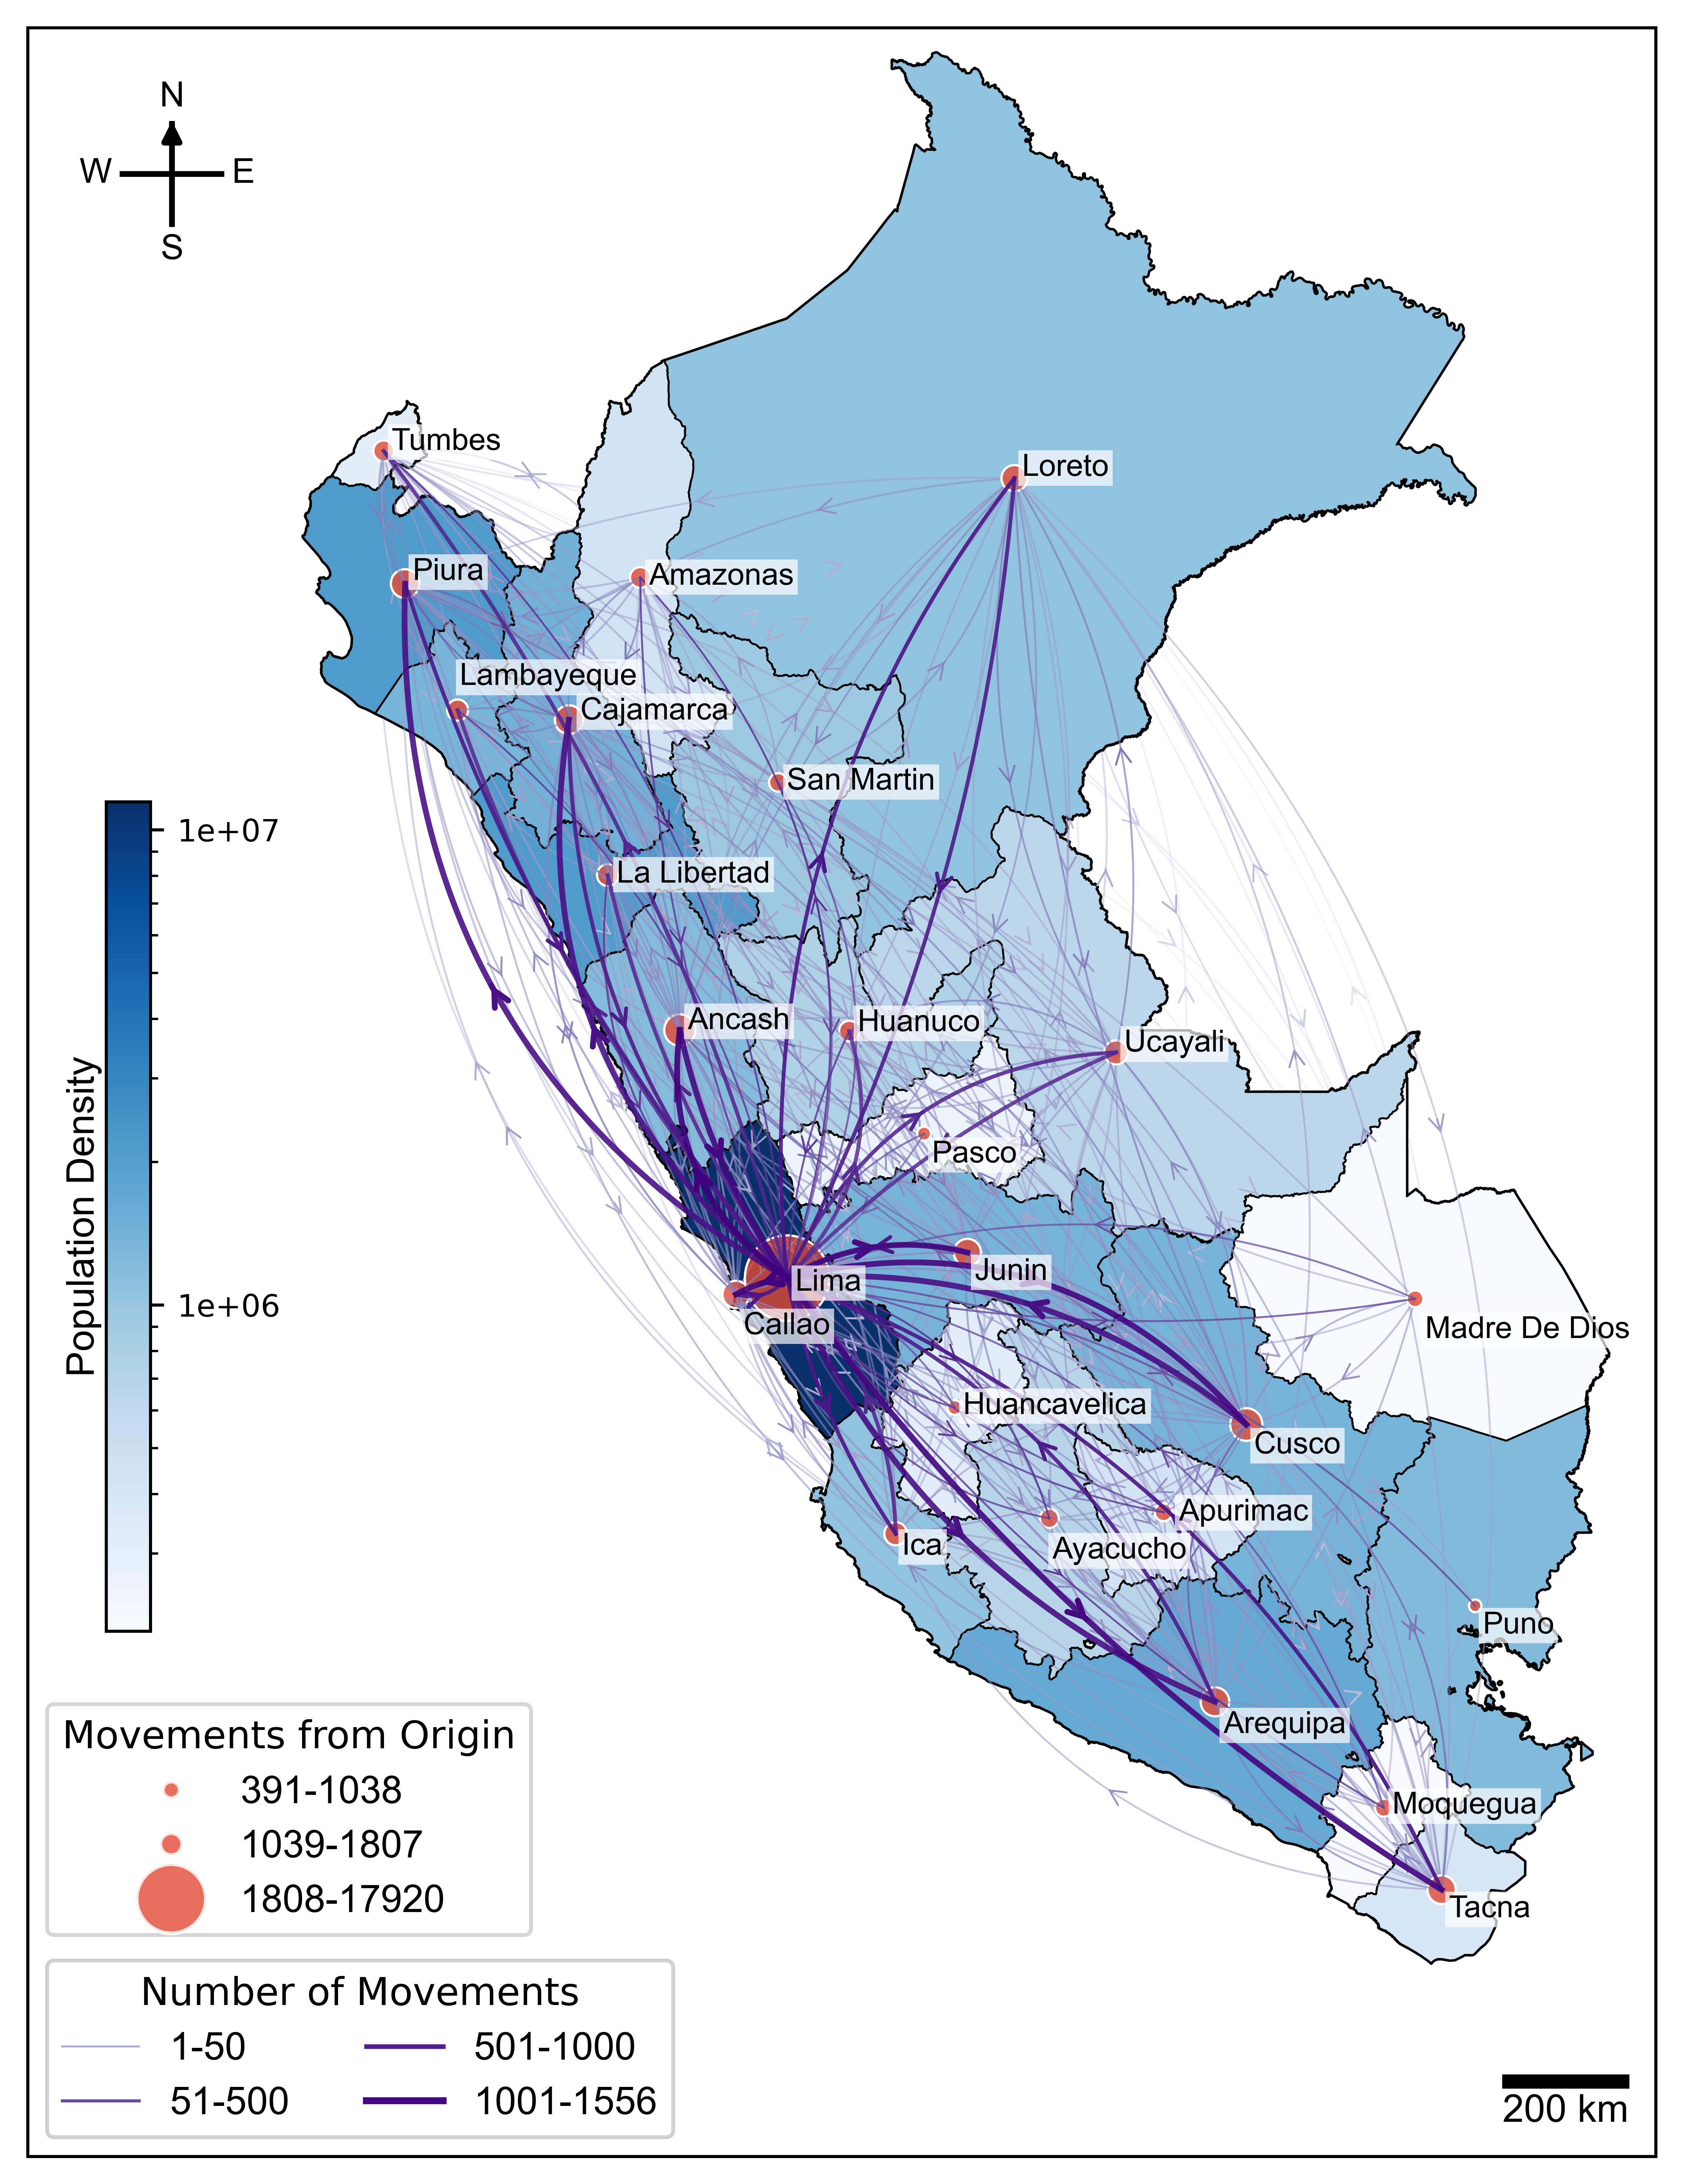

In [14]:
# ───────────────────── 14. GUARDAR Y MOSTRAR ───────────────────
fig.savefig("../output/Movimientos_Peru.jpg", dpi=800, bbox_inches="tight")
plt.show()
fig